In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
import joblib  # for saving the scaler

# ------------------------------------------------------
# Load CMAPSS dataset
# ------------------------------------------------------

def load_data(index="FD004", features=[2, 3, 4, 7, 11, 12, 15]):
    path = os.getcwd()
    train = np.loadtxt(os.path.join(path, f"train_{index}.txt"))
    test = np.loadtxt(os.path.join(path, f"test_{index}.txt"))
    labels = np.loadtxt(os.path.join(path, f"RUL_{index}.txt"))

    col_names = ["unit_number", "time"] + \
                [f"op_setting{i}" for i in range(1, 4)] + \
                [f"sensor{i}" for i in range(1, 22)]

    train_df = pd.DataFrame(train, columns=col_names)
    test_df = pd.DataFrame(test, columns=col_names)

    selected_features = [f"sensor{i}" for i in features]
    columns = ["unit_number", "time"] + selected_features

    return train_df[columns], test_df[columns], labels

# ------------------------------------------------------
# Compute RUL for training data
# ------------------------------------------------------

def compute_rul(df):
    rul = df.groupby("unit_number")["time"].max().reset_index()
    rul.columns = ["unit_number", "max_time"]
    df = df.merge(rul, on="unit_number")
    df["RUL"] = df["max_time"] - df["time"]
    return df.drop(columns=["max_time"])

# ------------------------------------------------------
# Prepare data: scaling and sequencing
# ------------------------------------------------------

def scale_and_split(train_df, sequence_length=50):
    features = train_df.columns.difference(["unit_number", "time", "RUL"])
    scaler = MinMaxScaler()
    train_df[features] = scaler.fit_transform(train_df[features])

    sequences, labels = [], []

    for _, group in train_df.groupby("unit_number"):
        group = group.reset_index(drop=True)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq[features].values)
            labels.append(seq["RUL"].values[-1])

    X = np.array(sequences)
    y = np.array(labels)
    return train_test_split(X, y, test_size=0.2, random_state=42), scaler

# ------------------------------------------------------
# Prepare test sequences
# ------------------------------------------------------

def prepare_test_data(test_df, rul_labels, scaler, sequence_length=50):
    features = test_df.columns.difference(["unit_number", "time"])
    test_df[features] = scaler.transform(test_df[features])

    sequences = []
    for _, group in test_df.groupby("unit_number"):
        group = group.reset_index(drop=True)
        if len(group) >= sequence_length:
            seq = group.iloc[-sequence_length:]
            sequences.append(seq[features].values)
        else:
            padding = np.zeros((sequence_length - len(group), len(features)))
            seq = np.vstack((padding, group[features].values))
            sequences.append(seq)

    X_test = np.array(sequences)
    y_test = rul_labels
    return X_test, y_test

# ------------------------------------------------------
# LSTM Model Definition
# ------------------------------------------------------

def build_lstm_model(input_shape):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ------------------------------------------------------
# Training Loop for All Datasets
# ------------------------------------------------------

def train_on_all_datasets():
    dataset_indices = ["FD001", "FD002", "FD003", "FD004"]
    sensor_features = [2, 3, 4, 7, 11, 12, 15]

    results = {}

    for index in dataset_indices:
        print(f"\n--- Training on {index} ---")
        # TODO: print dataframe
        train_df, test_df, rul_labels = load_data(index=index, features=sensor_features)
        train_df = compute_rul(train_df)

        (X_train, X_val, y_train, y_val), scaler = scale_and_split(train_df)

        # TODO: print this X_train.shape[1:] for the feature count
        model = build_lstm_model(input_shape=X_train.shape[1:])
        es = EarlyStopping(patience=10, restore_best_weights=True)

        model.fit(X_train, y_train, epochs=35, batch_size=64,
                  validation_data=(X_val, y_val), callbacks=[es], verbose=2)

        val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation Evaluation for {index}: MSE = {val_loss:.4f}, MAE = {val_mae:.4f}")

        # Test data evaluation
        X_test, y_test = prepare_test_data(test_df, rul_labels, scaler)
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Evaluation for {index}: MSE = {test_loss:.4f}, MAE = {test_mae:.4f}")

        # Save model and scaler
        model_dir = f"model_{index}"
        os.makedirs(model_dir, exist_ok=True)
        model.save(os.path.join(model_dir, "rul_lstm_model.h5"))
        joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

        results[index] = {
            "Val_MSE": val_loss, "Val_MAE": val_mae,
            "Test_MSE": test_loss, "Test_MAE": test_mae
        }

    print("\n--- Final Evaluation Summary ---")
    for k, v in results.items():
        print(f"{k}: Val_MSE = {v['Val_MSE']:.4f}, Val_MAE = {v['Val_MAE']:.4f}, "
              f"Test_MSE = {v['Test_MSE']:.4f}, Test_MAE = {v['Test_MAE']:.4f}")

if __name__ == "__main__":
    train_on_all_datasets()



--- Training on FD001 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/35
196/196 - 13s - 67ms/step - loss: 5630.7036 - mae: 57.7442 - val_loss: 3281.7620 - val_mae: 45.8331
Epoch 2/35
196/196 - 9s - 48ms/step - loss: 3310.3894 - mae: 46.4397 - val_loss: 3271.0237 - val_mae: 45.8515
Epoch 3/35
196/196 - 9s - 48ms/step - loss: 3277.6228 - mae: 46.2707 - val_loss: 3211.1841 - val_mae: 45.1425
Epoch 4/35
196/196 - 8s - 40ms/step - loss: 2739.3081 - mae: 41.2399 - val_loss: 1576.2616 - val_mae: 29.3298
Epoch 5/35
196/196 - 12s - 60ms/step - loss: 1401.6293 - mae: 26.5590 - val_loss: 1130.9592 - val_mae: 22.3539
Epoch 6/35
196/196 - 10s - 53ms/step - loss: 972.9747 - mae: 20.9779 - val_loss: 916.9340 - val_mae: 20.7730
Epoch 7/35
196/196 - 9s - 47ms/step - loss: 892.5873 - mae: 20.0671 - val_loss: 809.2531 - val_mae: 19.5052
Epoch 8/35
196/196 - 8s - 42ms/step - loss: 866.3208 - mae: 19.8422 - val_loss: 770.2211 - val_mae: 18.8111
Epoch 9/35
196/196 - 11s - 56ms/step - loss: 813.4131 - mae: 19.2554 - val_loss: 730.8541 - val_mae: 18.2669
Epoch 10/35
19

Validation Evaluation for FD001: MSE = 644.5764, MAE = 17.0226
Test Evaluation for FD001: MSE = 494.0195, MAE = 14.9690

--- Training on FD002 ---
Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 - 27s - 52ms/step - loss: 4255.8271 - mae: 51.1974 - val_loss: 3476.6304 - val_mae: 47.4776
Epoch 2/35
510/510 - 39s - 76ms/step - loss: 3313.5830 - mae: 46.4115 - val_loss: 3472.3115 - val_mae: 47.5695
Epoch 3/35
510/510 - 22s - 44ms/step - loss: 3307.2449 - mae: 46.4182 - val_loss: 3473.1331 - val_mae: 47.5428
Epoch 4/35
510/510 - 22s - 44ms/step - loss: 3314.9114 - mae: 46.4744 - val_loss: 3477.9097 - val_mae: 47.4578
Epoch 5/35
510/510 - 41s - 80ms/step - loss: 3301.9766 - mae: 46.3464 - val_loss: 3484.2812 - val_mae: 47.3984
Epoch 6/35
510/510 - 41s - 80ms/step - loss: 3314.7354 - mae: 46.4831 - val_loss: 3474.1460 - val_mae: 47.5152
Epoch 7/35
510/510 - 42s - 82ms/step - loss: 3307.4033 - mae: 46.4206 - val_loss: 3482.9277 - val_mae: 47.4014
Epoch 8/35
510/510 - 22s - 43ms/step - loss: 3307.6958 - mae: 46.4031 - val_loss: 3476.4771 - val_mae: 47.4253
Epoch 9/35
510/510 - 42s - 82ms/step - loss: 3304.4397 - mae: 46.4119 - val_loss: 3476.4529 - val_mae: 47.3236
Epoch 10/35


Test Evaluation for FD002: MSE = 2210.7046, MAE = 31.1324

--- Training on FD003 ---
Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 - 15s - 59ms/step - loss: 13260.2285 - mae: 84.2240 - val_loss: 8018.7832 - val_mae: 68.5056
Epoch 2/35
247/247 - 11s - 44ms/step - loss: 8209.7783 - mae: 70.0845 - val_loss: 8003.0830 - val_mae: 68.8596
Epoch 3/35
247/247 - 21s - 84ms/step - loss: 8202.9033 - mae: 70.1263 - val_loss: 7997.6533 - val_mae: 69.1937
Epoch 4/35
247/247 - 11s - 46ms/step - loss: 8215.1104 - mae: 70.0910 - val_loss: 7919.2300 - val_mae: 68.9596
Epoch 5/35
247/247 - 11s - 46ms/step - loss: 7072.9087 - mae: 62.9443 - val_loss: 3790.7925 - val_mae: 39.4388
Epoch 6/35
247/247 - 20s - 81ms/step - loss: 3278.7798 - mae: 37.9242 - val_loss: 2523.0056 - val_mae: 31.7227
Epoch 7/35
247/247 - 10s - 40ms/step - loss: 2785.1094 - mae: 34.8404 - val_loss: 2526.6772 - val_mae: 32.9270
Epoch 8/35
247/247 - 12s - 47ms/step - loss: 2509.6238 - mae: 32.9812 - val_loss: 2209.6794 - val_mae: 29.8424
Epoch 9/35
247/247 - 21s - 84ms/step - loss: 2445.0195 - mae: 32.5052 - val_loss: 2336.0056 - val_mae: 29.6405
Epoch 10/35

Validation Evaluation for FD003: MSE = 1531.9332, MAE = 24.6538
Test Evaluation for FD003: MSE = 1153.8152, MAE = 21.1957

--- Training on FD004 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/35
610/610 - 30s - 50ms/step - loss: 7965.3286 - mae: 69.1330 - val_loss: 6463.7227 - val_mae: 63.1988
Epoch 2/35
610/610 - 27s - 44ms/step - loss: 6321.3140 - mae: 63.6551 - val_loss: 6436.8892 - val_mae: 63.8784
Epoch 3/35
610/610 - 27s - 44ms/step - loss: 6316.0093 - mae: 63.6678 - val_loss: 6437.1670 - val_mae: 63.9161
Epoch 4/35
610/610 - 41s - 66ms/step - loss: 6309.2075 - mae: 63.5774 - val_loss: 6441.4971 - val_mae: 63.5145
Epoch 5/35
610/610 - 27s - 44ms/step - loss: 6309.4214 - mae: 63.5855 - val_loss: 6437.8140 - val_mae: 63.6274
Epoch 6/35
610/610 - 40s - 66ms/step - loss: 6319.2383 - mae: 63.6234 - val_loss: 6436.6968 - val_mae: 63.6047
Epoch 7/35
610/610 - 27s - 44ms/step - loss: 6286.6685 - mae: 63.4664 - val_loss: 6434.5776 - val_mae: 63.5482
Epoch 8/35
610/610 - 41s - 68ms/step - loss: 6298.0684 - mae: 63.4691 - val_loss: 6425.4150 - val_mae: 63.6115
Epoch 9/35
610/610 - 40s - 66ms/step - loss: 6297.2300 - mae: 63.5111 - val_loss: 6412.5190 - val_mae: 63.3608
E

Test Evaluation for FD004: MSE = 1800.8215, MAE = 32.9149

--- Final Evaluation Summary ---
FD001: Val_MSE = 644.5764, Val_MAE = 17.0226, Test_MSE = 494.0195, Test_MAE = 14.9690
FD002: Val_MSE = 1418.5281, Val_MAE = 27.8128, Test_MSE = 2210.7046, Test_MAE = 31.1324
FD003: Val_MSE = 1531.9332, Val_MAE = 24.6538, Test_MSE = 1153.8152, Test_MAE = 21.1957
FD004: Val_MSE = 3322.6951, Val_MAE = 41.6286, Test_MSE = 1800.8215, Test_MAE = 32.9149


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# ------------------------------
# Load Test Data
# ------------------------------

def load_test_data(index="FD001", features=[2, 3, 4, 7, 11, 12, 15]):
    path = os.getcwd()
    test = np.loadtxt(os.path.join(path, f"test_{index}.txt"))
    rul = np.loadtxt(os.path.join(path, f"RUL_{index}.txt"))

    col_names = ["unit_number", "time"] + \
                [f"op_setting{i}" for i in range(1, 4)] + \
                [f"sensor{i}" for i in range(1, 22)]

    test_df = pd.DataFrame(test, columns=col_names)
    selected_features = [f"sensor{i}" for i in features]
    columns = ["unit_number", "time"] + selected_features
    return test_df[columns], rul

# ------------------------------
# Prepare Test Sequences
# ------------------------------

def prepare_test_sequences(test_df, rul_labels, sequence_length=50):
    features = test_df.columns.difference(["unit_number", "time"])
    scaler = MinMaxScaler()
    test_df[features] = scaler.fit_transform(test_df[features])

    seq_data = []
    actual_rul = []

    for i, (_, group) in enumerate(test_df.groupby("unit_number")):
        group = group.reset_index(drop=True)
        if len(group) >= sequence_length:
            seq = group.iloc[-sequence_length:][features].values
        else:
            pad = np.zeros((sequence_length - len(group), len(features)))
            seq = np.vstack((pad, group[features].values))
        seq_data.append(seq)
        actual_rul.append(rul_labels[i])

    return np.array(seq_data), np.array(actual_rul)

# ------------------------------
# Predict RUL
# ------------------------------

def predict_rul_for_dataset(index="FD001"):
    print(f"\n--- Predicting for {index} ---")

    model_path = os.path.join("", f"lstm_{index}.h5")
    if not os.path.exists(model_path):
        print(f"Model not found for {index}. Train it first.")
        return

    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    features = [2, 3, 4, 7, 11, 12, 15]

    test_df, rul_labels = load_test_data(index=index, features=features)
    X_test, y_true = prepare_test_sequences(test_df, rul_labels)

    y_pred = model.predict(X_test).flatten()

    for i in range(min(10, len(y_true))):
        print(f"Unit {i+1}: Actual RUL = {y_true[i]:.1f}, Predicted RUL = {y_pred[i]:.1f}")

    mse = np.mean((y_pred - y_true)**2)
    mae = np.mean(np.abs(y_pred - y_true))
    print(f"\nTest MSE: {mse:.4f}, Test MAE: {mae:.4f}")


if __name__ == "__main__":
    predict_rul_for_dataset("FD001")
    predict_rul_for_dataset("FD002")
    predict_rul_for_dataset("FD003")
    predict_rul_for_dataset("FD004")



--- Predicting for FD001 ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Unit 1: Actual RUL = 112.0, Predicted RUL = 122.5
Unit 2: Actual RUL = 98.0, Predicted RUL = 101.6
Unit 3: Actual RUL = 69.0, Predicted RUL = 32.2
Unit 4: Actual RUL = 82.0, Predicted RUL = 60.3
Unit 5: Actual RUL = 91.0, Predicted RUL = 68.0
Unit 6: Actual RUL = 93.0, Predicted RUL = 99.7
Unit 7: Actual RUL = 91.0, Predicted RUL = 107.6
Unit 8: Actual RUL = 95.0, Predicted RUL = 53.0
Unit 9: Actual RUL = 111.0, Predicted RUL = 109.9
Unit 10: Actual RUL = 96.0, Predicted RUL = 57.2

Test MSE: 688.4432, Test MAE: 20.8549

--- Predicting for FD002 ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Unit 1: Actual RUL = 18.0, Predicted RUL = 13.7
Unit 2: Actual RUL = 79.0, Predicted RUL = 82.6
Unit 3: Actual RUL = 106.0, Predicted RUL = 91.1
Unit 4: Actual RUL = 110.0, Predicted RUL = 49.2
Unit 5: Actual RUL = 15.0, Predicted RUL = 22.1
Unit 6: Actual RUL = 155.0, Predicted RUL = 125.8
Unit 7: Actual RUL = 6.0, Predicted RUL = 9.5


Visualization


--- Predicting for FD001 ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Unit 1: Actual RUL = 112.0, Predicted RUL = 122.5
Unit 2: Actual RUL = 98.0, Predicted RUL = 101.6
Unit 3: Actual RUL = 69.0, Predicted RUL = 32.2
Unit 4: Actual RUL = 82.0, Predicted RUL = 60.3
Unit 5: Actual RUL = 91.0, Predicted RUL = 68.0
Unit 6: Actual RUL = 93.0, Predicted RUL = 99.7
Unit 7: Actual RUL = 91.0, Predicted RUL = 107.6
Unit 8: Actual RUL = 95.0, Predicted RUL = 53.0
Unit 9: Actual RUL = 111.0, Predicted RUL = 109.9
Unit 10: Actual RUL = 96.0, Predicted RUL = 57.2
Unit 11: Actual RUL = 97.0, Predicted RUL = 59.3
Unit 12: Actual RUL = 124.0, Predicted RUL = 91.2
Unit 13: Actual RUL = 95.0, Predicted RUL = 51.2
Unit 14: Actual RUL = 107.0, Predicted RUL = 70.1
Unit 15: Actual RUL = 83.0, Predicted RUL = 99.0
Unit 16: Actual RUL = 84.0, Predicted RUL = 122.4
Unit 17: Actual RUL = 50.0, Predicted RUL = 33.9
Unit 18: Actual RUL = 28.0, Predicted RUL = 18.4
Unit 19: Actual RUL = 87.0, Predicted RUL = 72.2
U

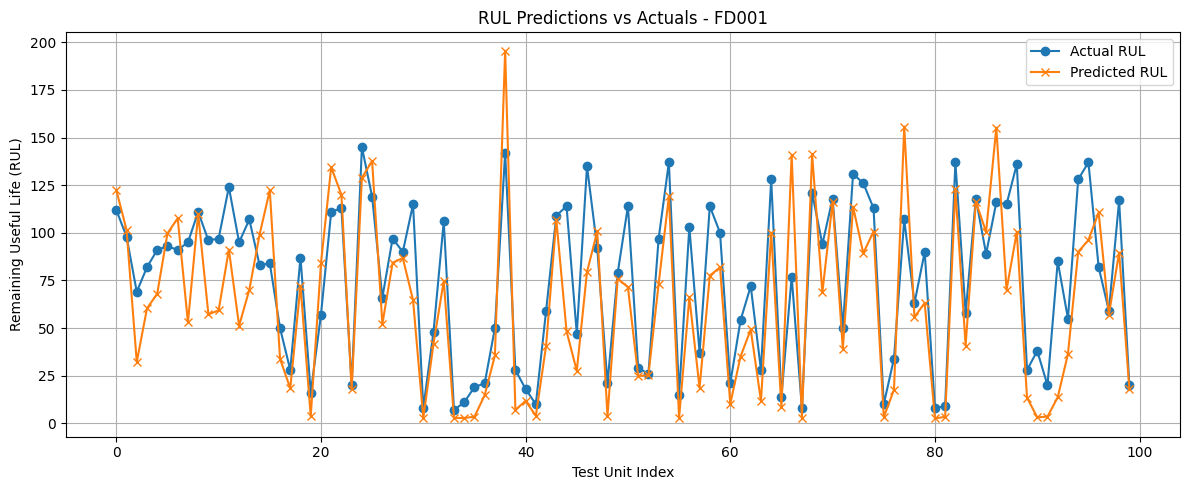

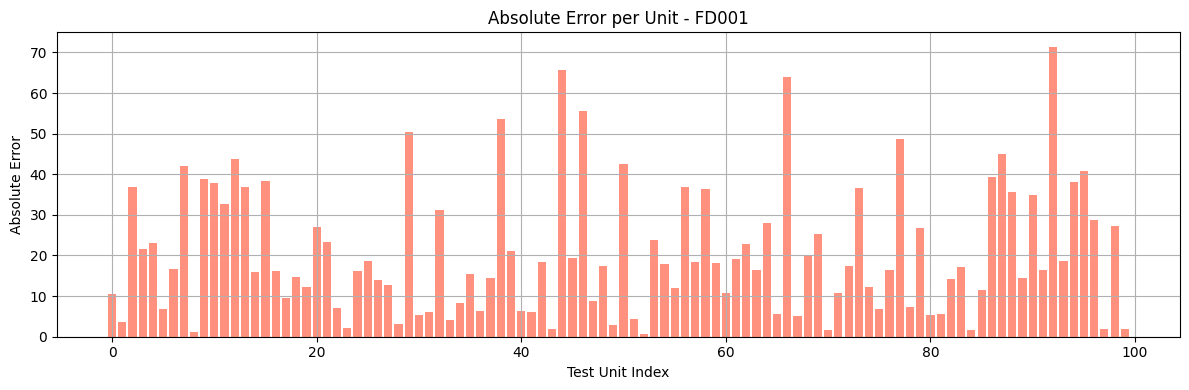


--- Predicting for FD002 ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Unit 1: Actual RUL = 18.0, Predicted RUL = 13.7
Unit 2: Actual RUL = 79.0, Predicted RUL = 82.6
Unit 3: Actual RUL = 106.0, Predicted RUL = 91.1
Unit 4: Actual RUL = 110.0, Predicted RUL = 49.2
Unit 5: Actual RUL = 15.0, Predicted RUL = 22.1
Unit 6: Actual RUL = 155.0, Predicted RUL = 125.8
Unit 7: Actual RUL = 6.0, Predicted RUL = 9.5
Unit 8: Actual RUL = 90.0, Predicted RUL = 43.2
Unit 9: Actual RUL = 11.0, Predicted RUL = 12.5
Unit 10: Actual RUL = 79.0, Predicted RUL = 87.3
Unit 11: Actual RUL = 6.0, Predicted RUL = 8.3
Unit 12: Actual RUL = 73.0, Predicted RUL = 100.5
Unit 13: Actual RUL = 30.0, Predicted RUL = 60.2
Unit 14: Actual RUL = 11.0, Predicted RUL = 5.2
Unit 15: Actual RUL = 37.0, Predicted RUL = 50.4
Unit 16: Actual RUL = 67.0, Predicted RUL = 79.6
Unit 17: Actual RUL = 68.0, Predicted RUL = 66.1
Unit 18: Actual RUL = 99.0, Predicted RUL = 23.7
Unit 19: Actual RUL = 22.0, Predicted RUL = 36.8
Unit 20: A

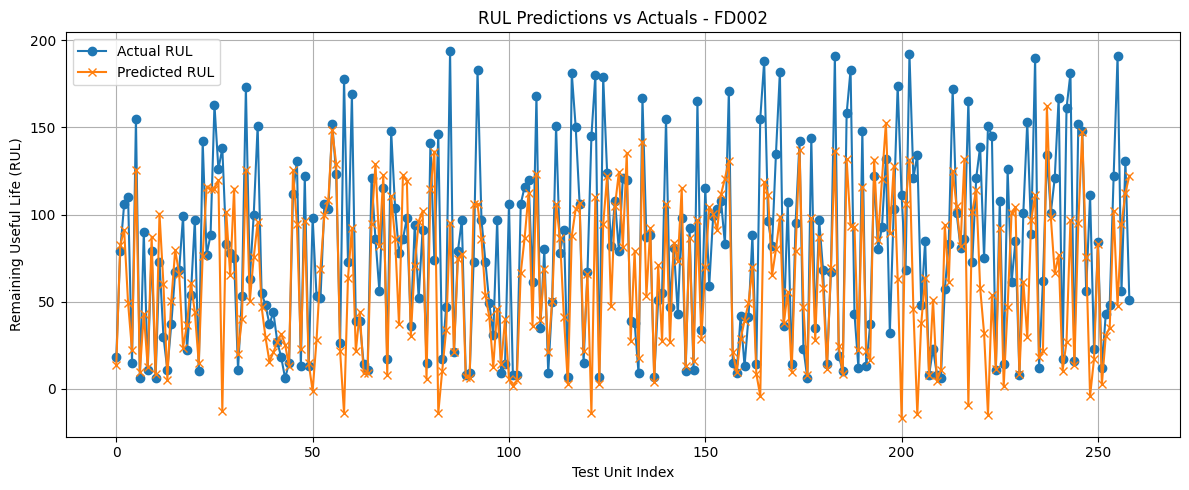

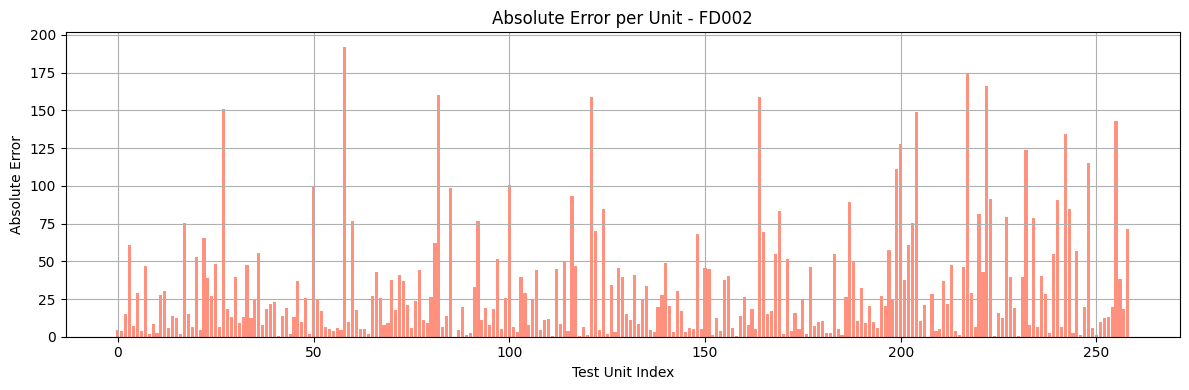


--- Predicting for FD003 ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Unit 1: Actual RUL = 44.0, Predicted RUL = 42.9
Unit 2: Actual RUL = 51.0, Predicted RUL = 33.3
Unit 3: Actual RUL = 27.0, Predicted RUL = 14.8
Unit 4: Actual RUL = 120.0, Predicted RUL = 93.9
Unit 5: Actual RUL = 101.0, Predicted RUL = 86.2
Unit 6: Actual RUL = 99.0, Predicted RUL = 113.3
Unit 7: Actual RUL = 71.0, Predicted RUL = 24.8
Unit 8: Actual RUL = 55.0, Predicted RUL = 17.6
Unit 9: Actual RUL = 55.0, Predicted RUL = 26.4
Unit 10: Actual RUL = 66.0, Predicted RUL = 66.0
Unit 11: Actual RUL = 77.0, Predicted RUL = 48.8
Unit 12: Actual RUL = 115.0, Predicted RUL = 55.8
Unit 13: Actual RUL = 115.0, Predicted RUL = 103.6
Unit 14: Actual RUL = 31.0, Predicted RUL = 13.0
Unit 15: Actual RUL = 108.0, Predicted RUL = 94.5
Unit 16: Actual RUL = 56.0, Predicted RUL = 75.0
Unit 17: Actual RUL = 136.0, Predicted RUL = 111.4
Unit 18: Actual RUL = 132.0, Predicted RUL = 97.5
Unit 19: Actual RUL = 85.0, Predicted RUL = 111.8

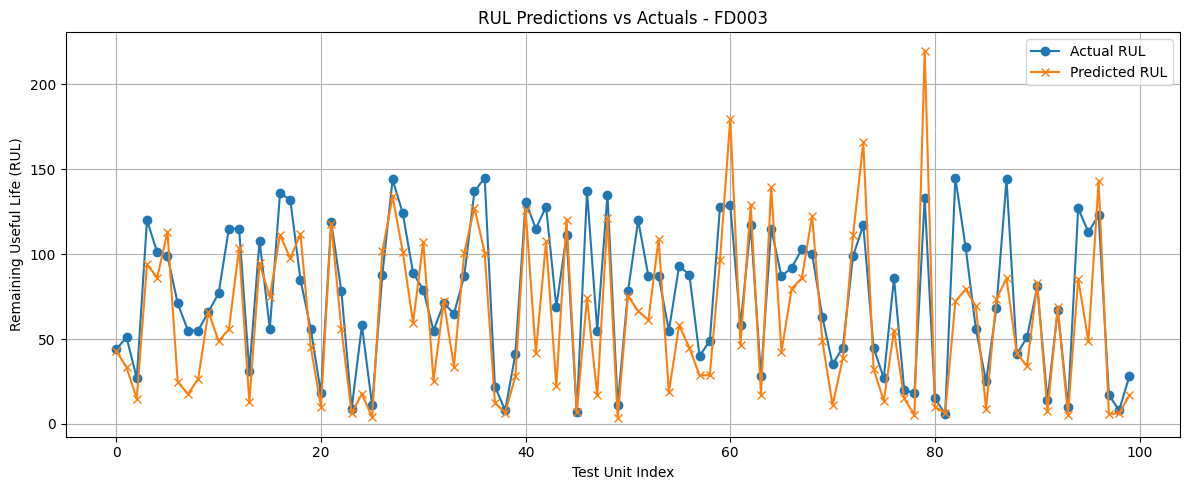

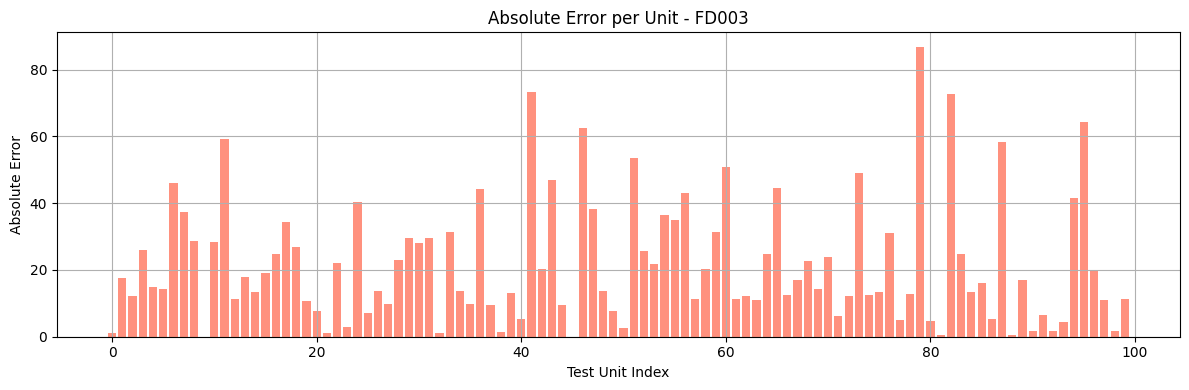


--- Predicting for FD004 ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Unit 1: Actual RUL = 22.0, Predicted RUL = 87.1
Unit 2: Actual RUL = 39.0, Predicted RUL = 34.1
Unit 3: Actual RUL = 107.0, Predicted RUL = 107.6
Unit 4: Actual RUL = 75.0, Predicted RUL = 120.4
Unit 5: Actual RUL = 149.0, Predicted RUL = 20.6
Unit 6: Actual RUL = 78.0, Predicted RUL = 118.8
Unit 7: Actual RUL = 94.0, Predicted RUL = 45.2
Unit 8: Actual RUL = 14.0, Predicted RUL = 8.8
Unit 9: Actual RUL = 99.0, Predicted RUL = 154.2
Unit 10: Actual RUL = 162.0, Predicted RUL = 103.0
Unit 11: Actual RUL = 143.0, Predicted RUL = 112.8
Unit 12: Actual RUL = 7.0, Predicted RUL = 7.3
Unit 13: Actual RUL = 71.0, Predicted RUL = 106.3
Unit 14: Actual RUL = 105.0, Predicted RUL = 58.1
Unit 15: Actual RUL = 12.0, Predicted RUL = 35.6
Unit 16: Actual RUL = 160.0, Predicted RUL = 152.2
Unit 17: Actual RUL = 162.0, Predicted RUL = 94.9
Unit 18: Actual RUL = 104.0, Predicted RUL = 87.9
Unit 19: Actual RUL = 194.0, Predicted RUL = 1

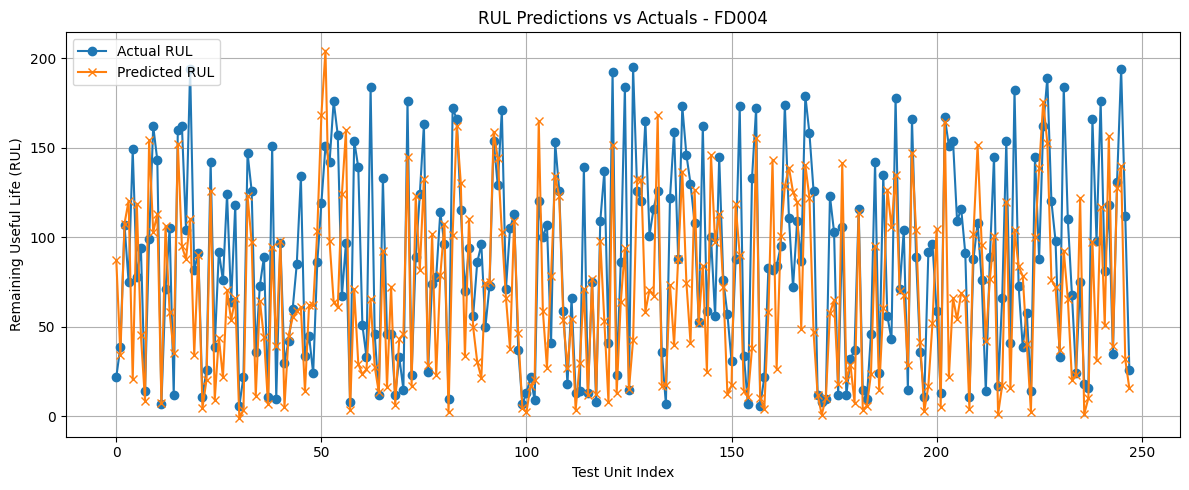

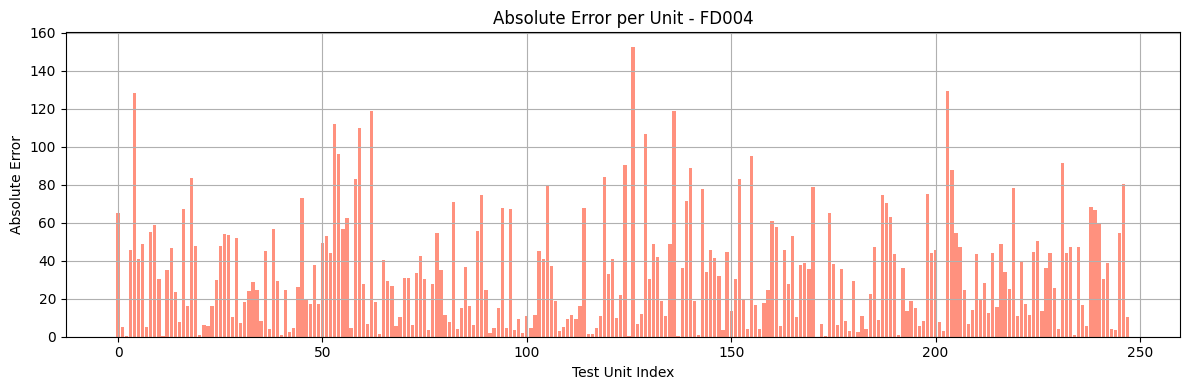

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

def load_data(index="FD001", features=[2, 3, 4, 7, 11, 12, 15]):
    path = os.getcwd()
    test = np.loadtxt(os.path.join(path, f"test_{index}.txt"))
    labels = np.loadtxt(os.path.join(path, f"RUL_{index}.txt"))

    col_names = ["unit_number", "time"] + \
                [f"op_setting{i}" for i in range(1, 4)] + \
                [f"sensor{i}" for i in range(1, 22)]

    test_df = pd.DataFrame(test, columns=col_names)
    selected_features = [f"sensor{i}" for i in features]
    columns = ["unit_number", "time"] + selected_features
    return test_df[columns], labels

def prepare_test_sequences(test_df, rul_labels, sequence_length=50):
    features = test_df.columns.difference(["unit_number", "time"])
    scaler = MinMaxScaler()
    test_df[features] = scaler.fit_transform(test_df[features])

    sequences = []
    true_rul = []

    for idx, (unit, group) in enumerate(test_df.groupby("unit_number")):
        group = group.reset_index(drop=True)
        if len(group) >= sequence_length:
            last_seq = group.iloc[-sequence_length:][features].values
        else:
            pad = np.zeros((sequence_length - len(group), len(features)))
            last_seq = np.vstack((pad, group[features].values))
        sequences.append(last_seq)
        true_rul.append(rul_labels[idx])

    return np.array(sequences), np.array(true_rul)

def plot_rul_predictions(true_rul, predicted_rul, index="FD001"):
    error = np.abs(true_rul - predicted_rul)

    # Line plot
    plt.figure(figsize=(12, 5))
    plt.plot(true_rul, label="Actual RUL", marker='o')
    plt.plot(predicted_rul, label="Predicted RUL", marker='x')
    plt.title(f"RUL Predictions vs Actuals - {index}")
    plt.xlabel("Test Unit Index")
    plt.ylabel("Remaining Useful Life (RUL)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Error plot
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(error)), error, color='tomato', alpha=0.7)
    plt.title(f"Absolute Error per Unit - {index}")
    plt.xlabel("Test Unit Index")
    plt.ylabel("Absolute Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def predict_rul_for_dataset(index="FD001", features=[2, 3, 4, 7, 11, 12, 15]):
    print(f"\n--- Predicting for {index} ---")
    test_df, labels = load_data(index=index, features=features)
    X_test, true_rul = prepare_test_sequences(test_df, labels)

    model_path = f"lstm_{index}.h5"
    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    predicted_rul = model.predict(X_test).flatten()

    for i in range(len(true_rul)):
        print(f"Unit {i+1}: Actual RUL = {true_rul[i]:.1f}, Predicted RUL = {predicted_rul[i]:.1f}")

    test_mse = mean_squared_error(true_rul, predicted_rul)
    test_mae = mean_absolute_error(true_rul, predicted_rul)

    print(f"\nTest MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

    plot_rul_predictions(true_rul, predicted_rul, index)

# Run for a dataset of your choice
predict_rul_for_dataset("FD001")
predict_rul_for_dataset("FD002")
predict_rul_for_dataset("FD003")
predict_rul_for_dataset("FD004")



--- Predicting for FD001 ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Unit 1: Actual RUL = 112.0, Predicted RUL = 122.5
Unit 2: Actual RUL = 98.0, Predicted RUL = 101.6
Unit 3: Actual RUL = 69.0, Predicted RUL = 32.2
Unit 4: Actual RUL = 82.0, Predicted RUL = 60.3
Unit 5: Actual RUL = 91.0, Predicted RUL = 68.0
Unit 6: Actual RUL = 93.0, Predicted RUL = 99.7
Unit 7: Actual RUL = 91.0, Predicted RUL = 107.6
Unit 8: Actual RUL = 95.0, Predicted RUL = 53.0
Unit 9: Actual RUL = 111.0, Predicted RUL = 109.9
Unit 10: Actual RUL = 96.0, Predicted RUL = 57.2
Unit 11: Actual RUL = 97.0, Predicted RUL = 59.3
Unit 12: Actual RUL = 124.0, Predicted RUL = 91.2
Unit 13: Actual RUL = 95.0, Predicted RUL = 51.2
Unit 14: Actual RUL = 107.0, Predicted RUL = 70.1
Unit 15: Actual RUL = 83.0, Predicted RUL = 99.0
Unit 16: Actual RUL = 84.0, Predicted RUL = 122.4
Unit 17: Actual RUL = 50.0, Predicted RUL = 33.9
Unit 18: Actual RUL = 28.0, Predicted RUL = 18.4
Unit 19: Actual RUL = 87.0, Predicted RUL = 72.2
U

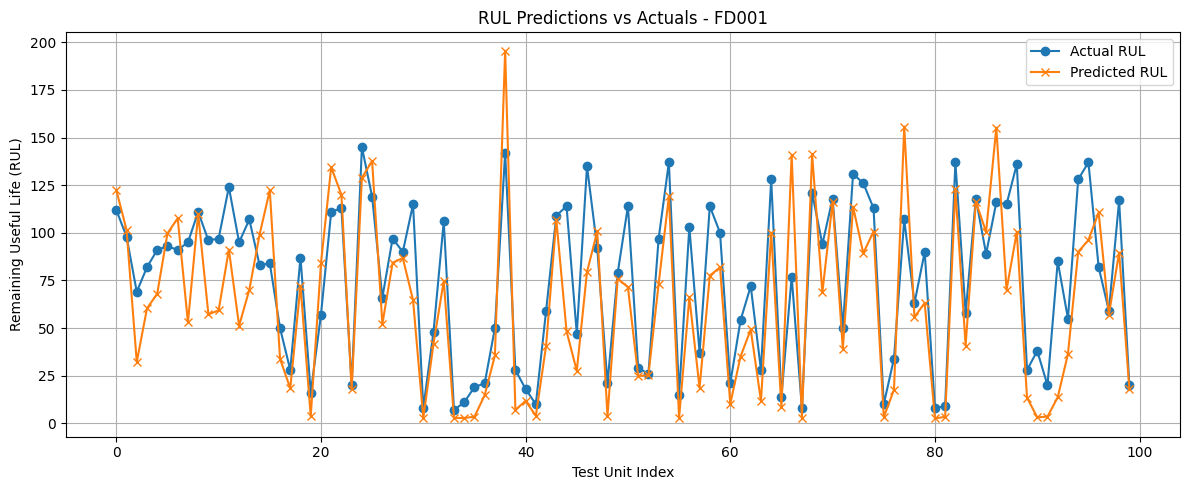

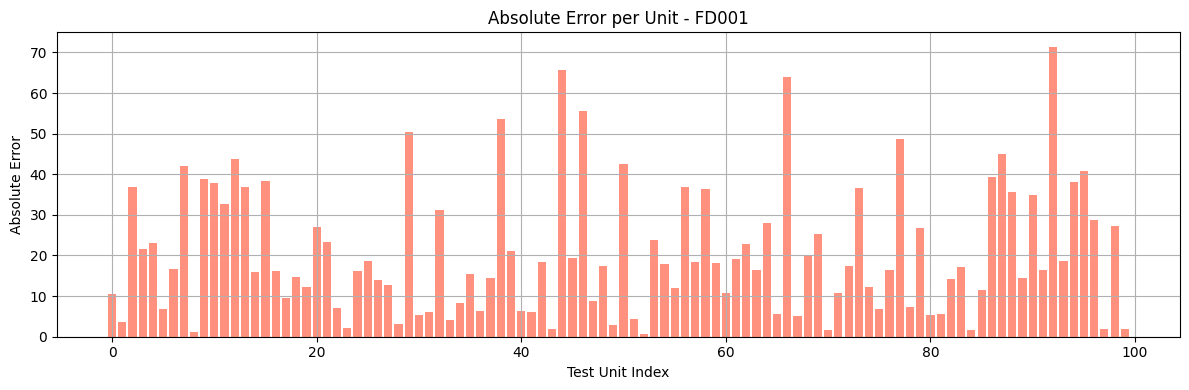

--- Performance on FD001 ---
MAE: 20.85
MSE: 688.44
RMSE: 26.24
R²: 0.60


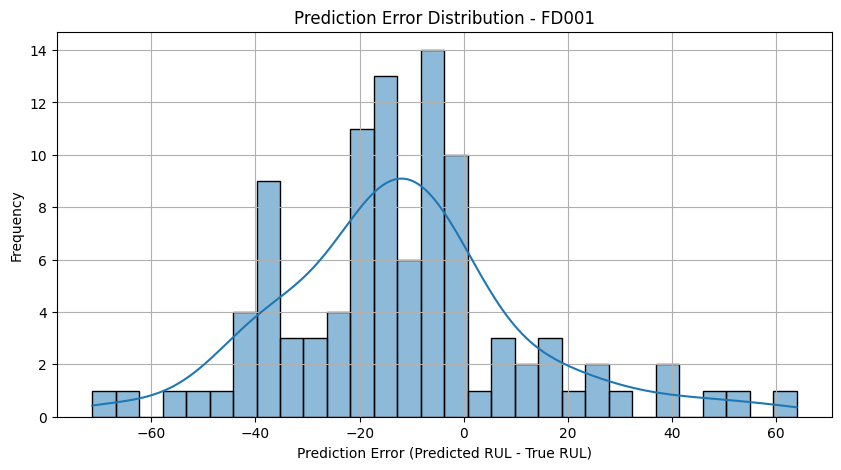


--- Predicting for FD002 ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Unit 1: Actual RUL = 18.0, Predicted RUL = 13.7
Unit 2: Actual RUL = 79.0, Predicted RUL = 82.6
Unit 3: Actual RUL = 106.0, Predicted RUL = 91.1
Unit 4: Actual RUL = 110.0, Predicted RUL = 49.2
Unit 5: Actual RUL = 15.0, Predicted RUL = 22.1
Unit 6: Actual RUL = 155.0, Predicted RUL = 125.8
Unit 7: Actual RUL = 6.0, Predicted RUL = 9.5
Unit 8: Actual RUL = 90.0, Predicted RUL = 43.2
Unit 9: Actual RUL = 11.0, Predicted RUL = 12.5
Unit 10: Actual RUL = 79.0, Predicted RUL = 87.3
Unit 11: Actual RUL = 6.0, Predicted RUL = 8.3
Unit 12: Actual RUL = 73.0, Predicted RUL = 100.5
Unit 13: Actual RUL = 30.0, Predicted RUL = 60.2
Unit 14: Actual RUL = 11.0, Predicted RUL = 5.2
Unit 15: Actual RUL = 37.0, Predicted RUL = 50.4
Unit 16: Actual RUL = 67.0, Predicted RUL = 79.6
Unit 17: Actual RUL = 68.0, Predicted RUL = 66.1
Unit 18: Actual RUL = 99.0, Predicted RUL = 23.7
Unit 19: Actual RUL = 22.0, Predicted RUL = 36.8
Unit 20: A

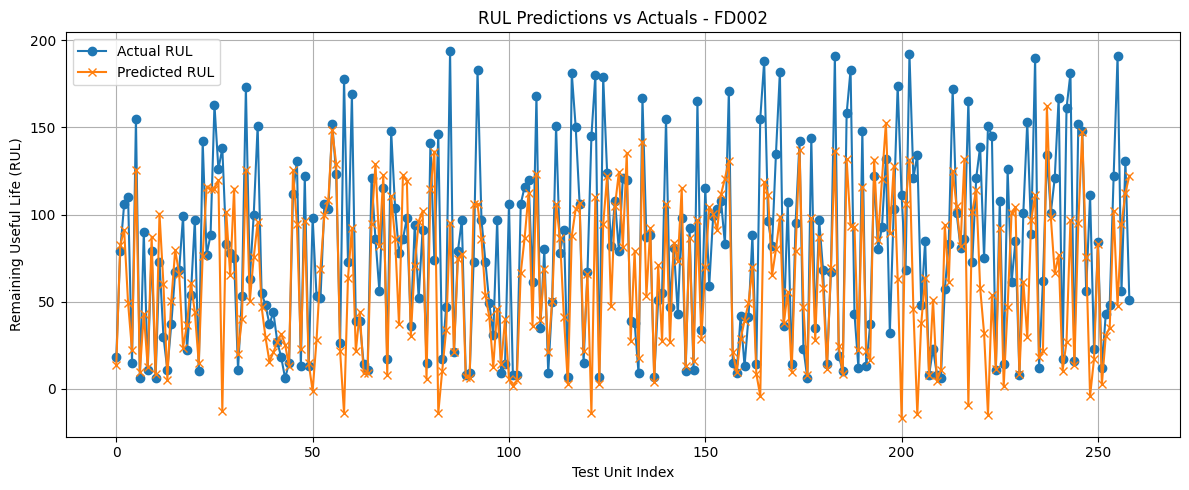

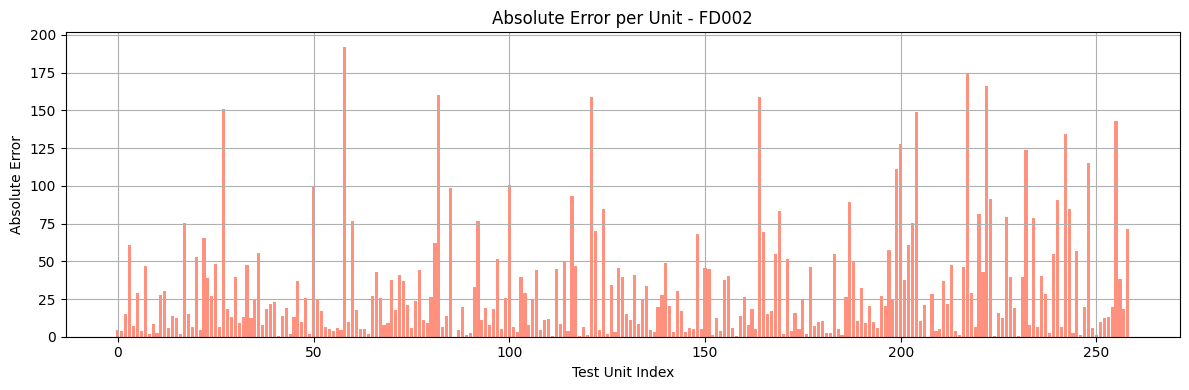

--- Performance on FD002 ---
MAE: 31.29
MSE: 2327.47
RMSE: 48.24
R²: 0.20


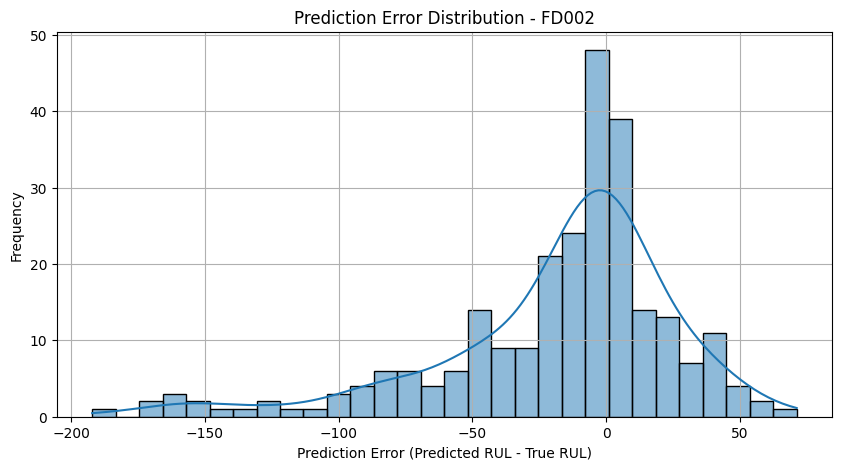


--- Predicting for FD003 ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
Unit 1: Actual RUL = 44.0, Predicted RUL = 42.9
Unit 2: Actual RUL = 51.0, Predicted RUL = 33.3
Unit 3: Actual RUL = 27.0, Predicted RUL = 14.8
Unit 4: Actual RUL = 120.0, Predicted RUL = 93.9
Unit 5: Actual RUL = 101.0, Predicted RUL = 86.2
Unit 6: Actual RUL = 99.0, Predicted RUL = 113.3
Unit 7: Actual RUL = 71.0, Predicted RUL = 24.8
Unit 8: Actual RUL = 55.0, Predicted RUL = 17.6
Unit 9: Actual RUL = 55.0, Predicted RUL = 26.4
Unit 10: Actual RUL = 66.0, Predicted RUL = 66.0
Unit 11: Actual RUL = 77.0, Predicted RUL = 48.8
Unit 12: Actual RUL = 115.0, Predicted RUL = 55.8
Unit 13: Actual RUL = 115.0, Predicted RUL = 103.6
Unit 14: Actual RUL = 31.0, Predicted RUL = 13.0
Unit 15: Actual RUL = 108.0, Predicted RUL = 94.5
Unit 16: Actual RUL = 56.0, Predicted RUL = 75.0
Unit 17: Actual RUL = 136.0, Predicted RUL = 111.4
Unit 18: Actual RUL = 132.0, Predicted RUL = 97.5
Unit 19: Actual RUL = 85.0, Predicted RUL = 111.

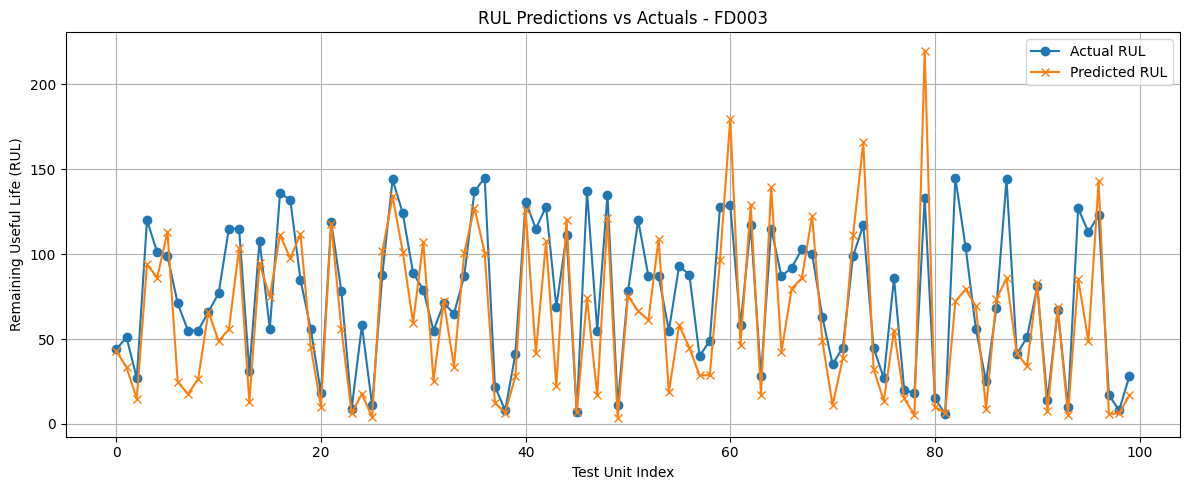

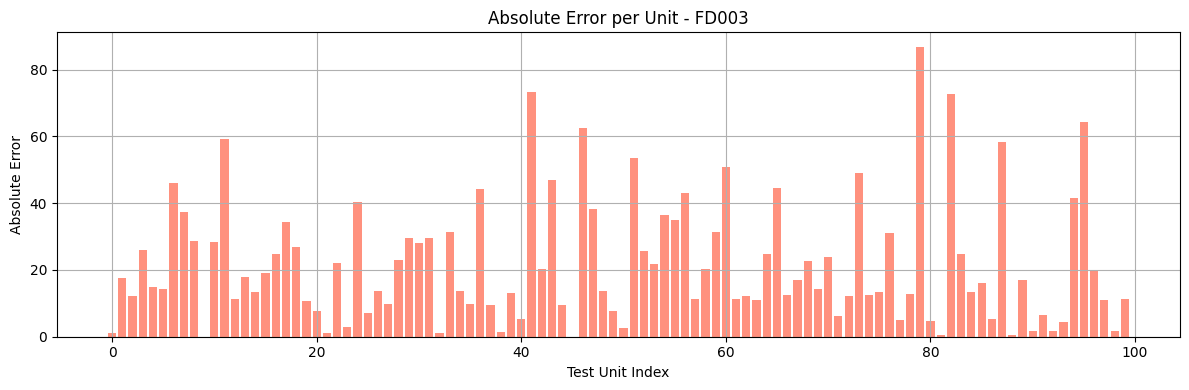

--- Performance on FD003 ---
MAE: 21.93
MSE: 821.51
RMSE: 28.66
R²: 0.52


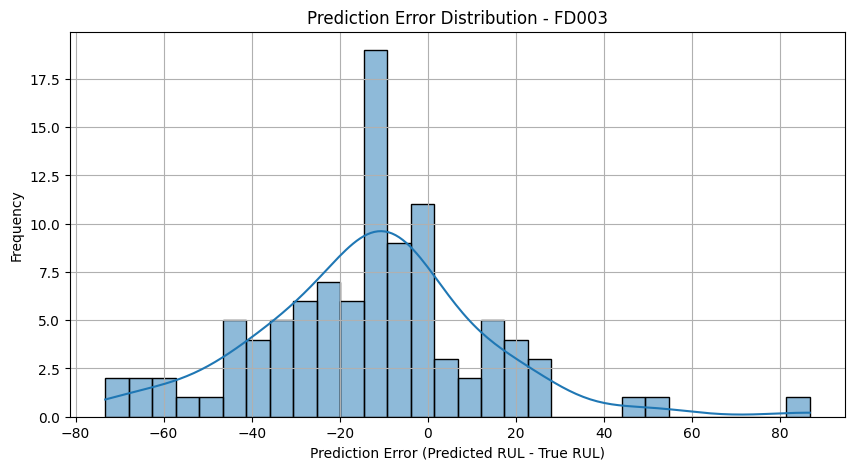


--- Predicting for FD004 ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Unit 1: Actual RUL = 22.0, Predicted RUL = 87.1
Unit 2: Actual RUL = 39.0, Predicted RUL = 34.1
Unit 3: Actual RUL = 107.0, Predicted RUL = 107.6
Unit 4: Actual RUL = 75.0, Predicted RUL = 120.4
Unit 5: Actual RUL = 149.0, Predicted RUL = 20.6
Unit 6: Actual RUL = 78.0, Predicted RUL = 118.8
Unit 7: Actual RUL = 94.0, Predicted RUL = 45.2
Unit 8: Actual RUL = 14.0, Predicted RUL = 8.8
Unit 9: Actual RUL = 99.0, Predicted RUL = 154.2
Unit 10: Actual RUL = 162.0, Predicted RUL = 103.0
Unit 11: Actual RUL = 143.0, Predicted RUL = 112.8
Unit 12: Actual RUL = 7.0, Predicted RUL = 7.3
Unit 13: Actual RUL = 71.0, Predicted RUL = 106.3
Unit 14: Actual RUL = 105.0, Predicted RUL = 58.1
Unit 15: Actual RUL = 12.0, Predicted RUL = 35.6
Unit 16: Actual RUL = 160.0, Predicted RUL = 152.2
Unit 17: Actual RUL = 162.0, Predicted RUL = 94.9
Unit 18: Actual RUL = 104.0, Predicted RUL = 87.9
Unit 19: Actual RUL = 194.0, Predicted RUL = 1

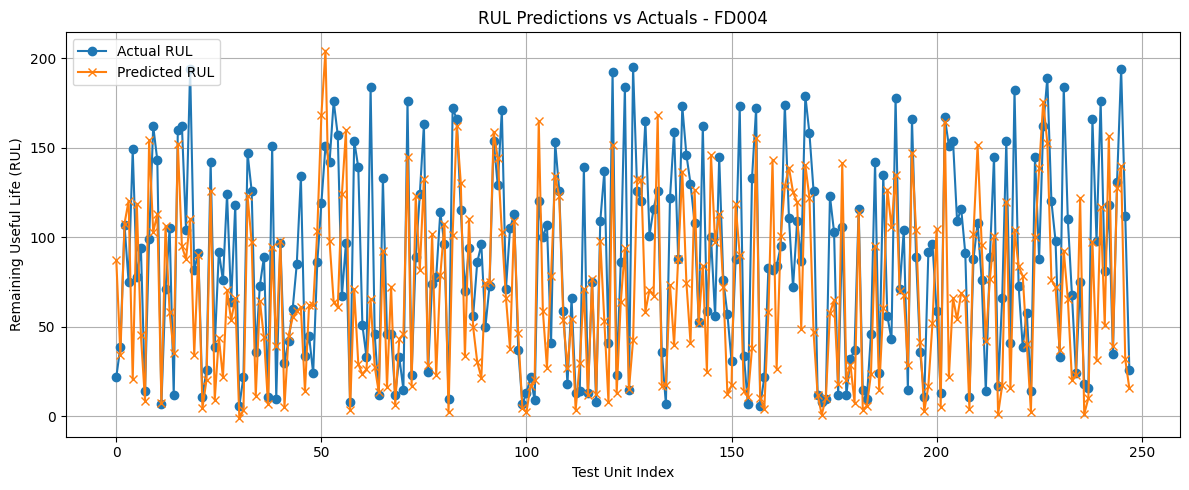

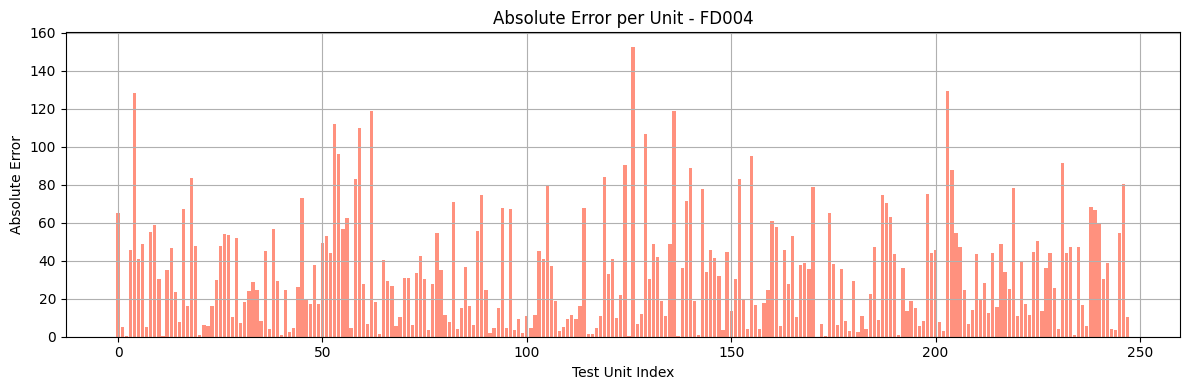

--- Performance on FD004 ---
MAE: 33.57
MSE: 1981.17
RMSE: 44.51
R²: 0.33


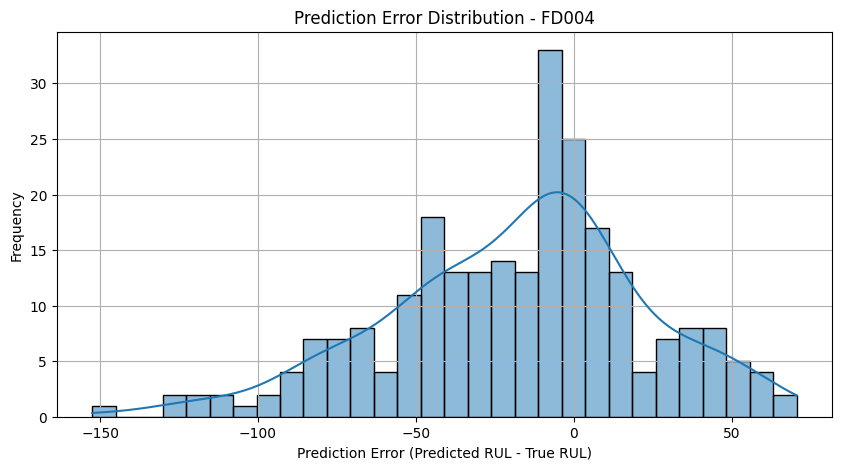

In [ ]:
def predict_rul_for_dataset(index="FD001", features=[2, 3, 4, 7, 11, 12, 15]):
    print(f"\n--- Predicting for {index} ---")
    test_df, labels = load_data(index=index, features=features)
    X_test, true_rul = prepare_test_sequences(test_df, labels)

    model_path = f"lstm_{index}.h5"
    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    predicted_rul = model.predict(X_test).flatten()

    for i in range(len(true_rul)):
        print(f"Unit {i+1}: Actual RUL = {true_rul[i]:.1f}, Predicted RUL = {predicted_rul[i]:.1f}")

    test_mse = mean_squared_error(true_rul, predicted_rul)
    test_mae = mean_absolute_error(true_rul, predicted_rul)

    print(f"\nTest MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

    plot_rul_predictions(true_rul, predicted_rul, index)

    # Evaluate model performance
    evaluate_model(true_rul, predicted_rul, index)

# Run for a dataset of your choice
predict_rul_for_dataset("FD001")
predict_rul_for_dataset("FD002")
predict_rul_for_dataset("FD003")
predict_rul_for_dataset("FD004")
